In [226]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("CA_data.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [227]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() 
print(missing_percentage)

id                                0
taxi_id                           0
trip_start_timestamp              0
trip_end_timestamp               11
trip_seconds                     50
trip_miles                       11
pickup_community_area         14485
dropoff_community_area        19567
fare                             20
tips                             20
tolls                         10153
extras                           20
trip_total                       20
payment_type                      0
company                           0
pickup_centroid_latitude      14458
pickup_centroid_longitude     14458
dropoff_centroid_latitude     18875
dropoff_centroid_longitude    18875
dtype: int64


In [209]:
train.head()

,id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude
0,1,fc7e6d61ad96136f2f84e65cb578719128a76777,2019-05-10T21:45:00Z,2019-05-10T22:00:00Z,420.0,0.00,8.0,8.0,6.00,0.00,0.0,0.0,6.00,Cash,Blue Ribbon Taxi Association Inc.,41.898332,-87.620763,41.907520,-87.626659
1,2,32e3320b2ad8fc0e4c90c95d962029be24d38ca2,2019-01-16T08:00:00Z,2019-01-16T08:00:00Z,419.0,1.00,8.0,8.0,6.25,1.00,0.0,0.0,7.75,Credit Card,City Service,41.892042,-87.631864,41.895033,-87.619711
2,3,39127d25654f081bbc273d7fe29e44c140d0c210,2018-10-27T14:30:00Z,2018-10-27T14:45:00Z,1175.0,3.30,33.0,8.0,13.25,3.31,NaN,0.0,16.56,Credit Card,Flash Cab,41.859350,-87.617358,41.892042,-87.631864
3,4,90bd7186d83d9653bd0453dd16c143941e597f6b,2019-09-25T17:30:00Z,2019-09-25T17:45:00Z,609.0,2.52,28.0,24.0,9.75,2.00,0.0,0.0,12.25,Credit Card,Sun Taxi,41.874005,-87.663518,41.901207,-87.676356
4,5,455653ef8a20a3125f30a4938ec1eedadef50ab5,2018-12-14T15:15:00Z,2018-12-14T15:30:00Z,1026.0,1.60,NaN,NaN,10.00,2.00,0.0,0.0,12.50,Credit Card,Flash Cab,NaN,NaN,NaN,NaN


In [228]:
# Define public holidays
public_holidays = [
    "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-05", "2018-05-28",
    "2018-07-04", "2018-09-03", "2018-10-08", "2018-11-11", "2018-11-22",
    "2018-12-25", "2018-02-12", "2019-01-01", "2019-01-21", "2019-02-18",
    "2019-03-04", "2019-05-27", "2019-07-04", "2019-09-02", "2019-10-14",
    "2019-11-11", "2019-11-28", "2019-12-25", "2019-02-12"
]

# Convert trip_start_timestamp to datetime
train['trip_start_timestamp'] = pd.to_datetime(train['trip_start_timestamp'])

# Add is_working_day#
train['is_working_day'] = np.where(
    (train['trip_start_timestamp'].dt.weekday.isin(range(0, 5))) & 
    (~train['trip_start_timestamp'].dt.strftime('%Y-%m-%d').isin(public_holidays)), 
    1, 0
)

#train['is_working_day'] = train['trip_start_timestamp'].dt.weekday < 5

# Add is_rush_hour
train['is_rush_hour'] = np.where(
    ((train['trip_start_timestamp'].dt.hour.isin([7, 8, 9]) &
      (train['trip_start_timestamp'].dt.minute <= 59)) |
     (train['trip_start_timestamp'].dt.hour.isin([16, 17, 18]) &
      (train['trip_start_timestamp'].dt.minute <= 59))) &
    (train['is_working_day'] == 1),
    1, 0
)

In [229]:
# Define the list of columns to display
columns_to_display = ['is_working_day', 'is_rush_hour', 'trip_start_timestamp']

# Display the first few rows of these columns
train[columns_to_display].head()

,is_working_day,is_rush_hour,trip_start_timestamp
0,1,0,2019-05-10 21:45:00+00:00
1,1,1,2019-01-16 08:00:00+00:00
2,0,0,2018-10-27 14:30:00+00:00
3,1,1,2019-09-25 17:30:00+00:00
4,1,0,2018-12-14 15:15:00+00:00


In [230]:
# Fill missing values for numeric columns with mode
for col in ['trip_seconds', 'trip_miles']:
    train[col] = train[col].fillna(train[col].mode()[0])

# VERSION 1

In [231]:
# Function to get mode
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else 0

# Group by taxi_id and calculate modes
modes = train.groupby('taxi_id').agg({
    'pickup_community_area': get_mode,
    'dropoff_community_area': get_mode,
    'pickup_centroid_latitude': get_mode,
    'pickup_centroid_longitude': get_mode,
    'dropoff_centroid_latitude': get_mode,
    'dropoff_centroid_longitude': get_mode
}).reset_index()

# Merge with train
train = train.merge(modes, on='taxi_id', suffixes=('', '_mode'))

# Fill missing values with group modes
for col in [
    'pickup_community_area', 'dropoff_community_area',
    'pickup_centroid_latitude', 'pickup_centroid_longitude',
    'dropoff_centroid_latitude', 'dropoff_centroid_longitude'
]:
    train[col] = train[col].fillna(train[f"{col}_mode"]).fillna(0)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Create mile/time column, avoiding division by zero
train['mile/time'] = train['trip_miles'] / train['trip_seconds']

# Calculate the mean or mode of the entire `mile/time` column
global_mean = train['mile/time'][~train['mile/time'].isin([np.inf, -np.inf])].mean()

# Replace invalid values (infinite or NaN) with the global mean
train['mile/time'] = train['mile/time'].replace([np.inf, -np.inf], np.nan).fillna(global_mean)

# VERSION 2

In [232]:
# Function to calculate mode safely
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan

# Iterate over each column and fill missing values with mode grouped by taxi_id
for col in [
    'pickup_community_area', 'dropoff_community_area',
    'pickup_centroid_latitude', 'pickup_centroid_longitude',
    'dropoff_centroid_latitude', 'dropoff_centroid_longitude'
]:
    # Calculate mode for each taxi_id
    mode_by_taxi_id = train.groupby('taxi_id')[col].transform(get_mode)
    
    # Fill missing values in the column with the mode of the corresponding taxi_id group
    train[col] = train[col].fillna(mode_by_taxi_id)


# Create mile/time column, avoiding division by zero
train['mile/time'] = train['trip_miles'] / train['trip_seconds']

# Calculate the mean or mode of the entire `mile/time` column
global_mean = train['mile/time'][~train['mile/time'].isin([np.inf, -np.inf])].mean()

# Replace invalid values (infinite or NaN) with the global mean
train['mile/time'] = train['mile/time'].replace([np.inf, -np.inf], np.nan).fillna(global_mean)

In [233]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() 
print(missing_percentage)

id                                     0
taxi_id                                0
trip_start_timestamp                   0
trip_end_timestamp                    11
trip_seconds                           0
trip_miles                             0
pickup_community_area                  0
dropoff_community_area                 0
fare                                  20
tips                                  20
tolls                              10153
extras                                20
trip_total                            20
payment_type                           0
company                                0
pickup_centroid_latitude               0
pickup_centroid_longitude              0
dropoff_centroid_latitude              0
dropoff_centroid_longitude             0
is_working_day                         0
is_rush_hour                           0
pickup_community_area_mode             0
dropoff_community_area_mode            0
pickup_centroid_latitude_mode          0
pickup_centroid_

In [234]:
# Drop unnecessary columns
train = train.drop(columns=[
    'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 
    'payment_type', 'tolls', 'id','trip_total','company'
])

In [235]:
# Encode categorical columns
for col in train.select_dtypes('object').columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

In [236]:
# Split data into training, validation, and test sets
X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [237]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Train XGBoost model
xgb_model = xgb.train(
    {
        'max_depth': 5,
        'eta': 0.2,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
    },
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=500
)

[0]	train-auc:0.76072	val-auc:0.75888
[1]	train-auc:0.77364	val-auc:0.77314
[2]	train-auc:0.77827	val-auc:0.77747
[3]	train-auc:0.78198	val-auc:0.78062
[4]	train-auc:0.78356	val-auc:0.78232
[5]	train-auc:0.78582	val-auc:0.78472
[6]	train-auc:0.78739	val-auc:0.78599
[7]	train-auc:0.78882	val-auc:0.78715
[8]	train-auc:0.78996	val-auc:0.78801
[9]	train-auc:0.79092	val-auc:0.78871
[10]	train-auc:0.79220	val-auc:0.78974
[11]	train-auc:0.79286	val-auc:0.79025
[12]	train-auc:0.79372	val-auc:0.79103
[13]	train-auc:0.79441	val-auc:0.79142
[14]	train-auc:0.79504	val-auc:0.79193
[15]	train-auc:0.79544	val-auc:0.79194
[16]	train-auc:0.79609	val-auc:0.79266
[17]	train-auc:0.79665	val-auc:0.79304
[18]	train-auc:0.79713	val-auc:0.79339
[19]	train-auc:0.79764	val-auc:0.79361
[20]	train-auc:0.79796	val-auc:0.79376
[21]	train-auc:0.79850	val-auc:0.79412
[22]	train-auc:0.79908	val-auc:0.79440
[23]	train-auc:0.79934	val-auc:0.79436
[24]	train-auc:0.79972	val-auc:0.79459
[25]	train-auc:0.80003	val-auc:0.79

In [238]:
# Predict on test set
y_pred = xgb_model.predict(dtest)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score:.4f}")

Confusion Matrix:
[[19654  2131]
 [ 5172  3043]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     21785
           1       0.59      0.37      0.45      8215

    accuracy                           0.76     30000
   macro avg       0.69      0.64      0.65     30000
weighted avg       0.74      0.76      0.74     30000

AUC: 0.7977


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


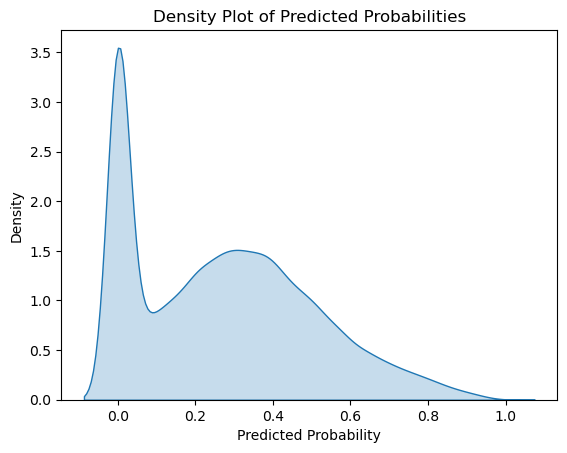

In [239]:
# Plot density of predictions
sns.kdeplot(y_pred, label="Predicted Probabilities", fill=True)
plt.title("Density Plot of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.show()

In [256]:
# Predict probabilities on the test set
y_pred_prob_xgb = xgb_model.predict(dtest)

# Convert probabilities to binary predictions (threshold = 0.2)
y_pred_xgb = (y_pred_prob_xgb >= 0.25).astype(int)

In [257]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix_xgb.ravel()

Confusion Matrix:
[[13120  8665]
 [ 1371  6844]]


In [258]:
# Calculate recall for each class
recall_class_0 = TN / (TN + FP)  # Recall for class 0
recall_class_1 = TP / (TP + FN)  # Recall for class 1

# Calculate balanced accuracy
balanced_accuracy_xgb = (recall_class_0 + recall_class_1) / 2
print(f"Balanced Accuracy: {balanced_accuracy_xgb:.4f}")

Balanced Accuracy: 0.7177


In [259]:
from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy
balanced_accuracy_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print(f"Balanced Accuracy (Sklearn): {balanced_accuracy_xgb:.4f}")

Balanced Accuracy (Sklearn): 0.7177


In [245]:
# Extract feature importance metrics
importance_gain = xgb_model.get_score(importance_type='gain')
importance_cover = xgb_model.get_score(importance_type='cover')
importance_weight = xgb_model.get_score(importance_type='weight')

# Combine into a DataFrame
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),  # Feature names
    'Gain': list(importance_gain.values()),   # Gain values
    'Cover': [importance_cover.get(k, 0) for k in importance_gain.keys()],  # Cover values
    'Frequency': [importance_weight.get(k, 0) for k in importance_gain.keys()]  # Frequency (weight)
}).sort_values(by='Gain', ascending=False)  # Sort by Gain

print(feature_importance_df)

                            Feature         Gain         Cover  Frequency
11                   is_working_day  1347.435303  23335.634766       50.0
18                        mile/time    10.578718   3757.558838     2246.0
0                      trip_seconds     6.950381   3749.812744     2118.0
6                            extras     5.636935   6741.826660      979.0
9         dropoff_centroid_latitude     5.098164   3067.832764     1207.0
7          pickup_centroid_latitude     4.097398   4854.930176     1165.0
8         pickup_centroid_longitude     4.094648   3753.383057     1141.0
2             pickup_community_area     4.019807   2208.168945      538.0
10       dropoff_centroid_longitude     3.916894   3086.062500     1253.0
3            dropoff_community_area     3.802196   2444.741211      667.0
4                              fare     3.775081   4421.526855     1624.0
13      dropoff_community_area_mode     3.517410   4232.597656      358.0
1                        trip_miles   

## TRAIN WITH LG INSTEAD

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [57]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() 
#missing_percentage = train.isna().sum() / len(train)

print(missing_percentage)

trip_seconds                          0
trip_miles                            0
pickup_community_area                 0
dropoff_community_area                0
fare                                 20
tips                                 20
extras                               20
trip_total                           20
company                               0
pickup_centroid_latitude              0
pickup_centroid_longitude             0
dropoff_centroid_latitude             0
dropoff_centroid_longitude            0
is_working_day                        0
is_rush_hour                          0
pickup_community_area_mode         2707
dropoff_community_area_mode        2685
pickup_centroid_latitude_mode      2680
pickup_centroid_longitude_mode     2680
dropoff_centroid_latitude_mode     2685
dropoff_centroid_longitude_mode    2685
mile/time                             0
dtype: int64


In [58]:
# Fill NaN values in X_train and X_test with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [59]:
# Define features (X) and target variable (y)
X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [60]:
# Fill NaN values in X_train and X_test with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)

In [61]:
# Initialize logistic regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [62]:
# Predict on the validation set
y_val_pred = logreg_model.predict(X_val)
y_val_pred_prob = logreg_model.predict_proba(X_val)[:, 1]  # Predicted probabilities for the positive class

In [63]:
# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Validation AUC: {auc:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

Validation Accuracy: 0.7232
Validation AUC: 0.7306
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84     21807
           1       0.40      0.03      0.05      8193

    accuracy                           0.72     30000
   macro avg       0.57      0.51      0.45     30000
weighted avg       0.64      0.72      0.62     30000

Confusion Matrix:
[[21469   338]
 [ 7965   228]]


In [65]:
# Predict on the test set
y_test_pred = logreg_model.predict(X_test)
y_test_pred_prob = logreg_model.predict_proba(X_test)[:, 1]

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# AUC
test_auc = roc_auc_score(y_test, y_test_pred_prob)
print(f"Test AUC: {test_auc:.4f}")

# Classification Report
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(conf_matrix_test)

Test Accuracy: 0.7223
Test AUC: 0.7243
Test Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84     21785
           1       0.40      0.03      0.05      8215

    accuracy                           0.72     30000
   macro avg       0.56      0.51      0.44     30000
weighted avg       0.64      0.72      0.62     30000

Test Confusion Matrix:
[[21440   345]
 [ 7987   228]]


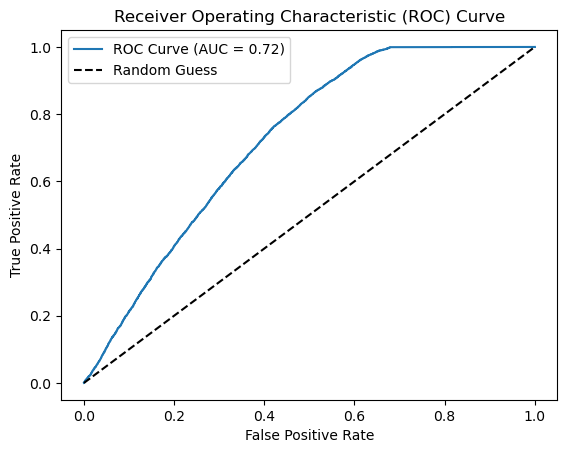

In [66]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

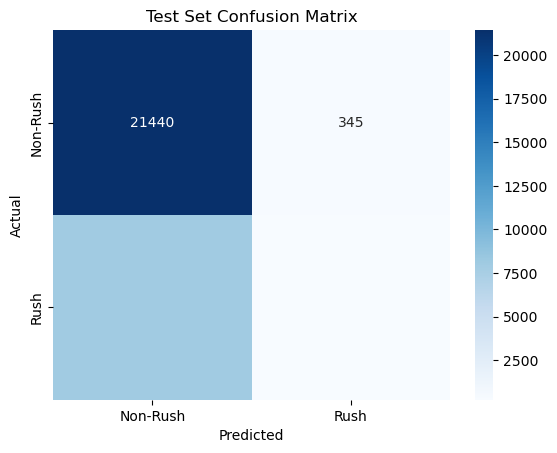

In [67]:
import seaborn as sns

# Heatmap for Confusion Matrix
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rush', 'Rush'], yticklabels=['Non-Rush', 'Rush'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()

In [68]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

# Predict binary outcomes on the test set
y_pred = logreg_model.predict(X_test)

In [69]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate recall for each class
recall_class_0 = TN / (TN + FP)  # Recall for class 0
recall_class_1 = TP / (TP + FN)  # Recall for class 1

# Calculate balanced accuracy
balanced_accuracy = (recall_class_0 + recall_class_1) / 2
print(f"Balanced Accuracy (Manual): {balanced_accuracy:.4f}")

Confusion Matrix:
[[21440   345]
 [ 7987   228]]
Balanced Accuracy (Manual): 0.5060
